## Comparison

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Function Definitions

### Make_graph

In [2]:
def make_graph(G):
    # check if Graph is directed
    print('Directed:', nx.is_directed(G))

    # check if Graph is weighted
    print('Weighted:', nx.is_weighted(G))
    print()
    
    # converting to directed Graph for PageRank
    if not nx.is_directed(G):
        print('Graph converted to directed..')
        G = G.to_directed()    

    print('Directed:', nx.is_directed(G))
    print()

    # labelling nodes as integers
    print('Relabelling nodes to integers..')
    n_unique_nodes = len(set(G.nodes()))
    node2int = dict(zip(set(G.nodes()), range(n_unique_nodes)))
    int2node = {v:k for k,v in node2int.items()}

    G = nx.relabel_nodes(G, node2int)

    # remove isolated nodes
    print('Removing isolated nodes..')
    nodes = G.nodes()
    for node in nodes:
        if len(G.edges(node))==0:
            G.remove_node(node)
    return G, int2node           

### Plot_graph

In [3]:
def plot_graph(G, final_probs, int2node, bool_final_probs=False):
    
    # defining labels
    labels = int2node

    # zachary karate club
    try:
        clubs = np.array(list(map(lambda x: G.nodes[x]['club'], G.nodes())))
        labels = dict(zip(G.nodes(), clubs)) 
    except:
        pass   

    if not bool_final_probs:
        nx.draw(G, with_labels=True, alpha=0.8, arrows=False, labels=labels)
    else:
        nx.draw(G, with_labels=True, alpha=0.8, arrows=False, node_color = final_probs, \
                                                                                        cmap=plt.get_cmap('viridis'), labels=labels)

        # adding color bar for pagerank importances
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('viridis'), norm=plt.Normalize(vmin = min(final_probs), vmax=max(final_probs)))
        sm._A = []
        plt.colorbar(sm)  
    return plt

### Make_pagerank_matrix

In [4]:
def make_pagerank_matrix(G, alpha):
    n_nodes = len(G.nodes())

    # building adjacent matrix
    adj_matrix = np.zeros(shape=(n_nodes, n_nodes))
    for edge in G.edges():
        adj_matrix[edge[0], edge[1]] = 1

    # building transition probability matrix
    tran_matrix = adj_matrix / np.sum(adj_matrix, axis=1).reshape(-1,1)

    # building random surfer matrix
    random_surf = np.ones(shape = (n_nodes, n_nodes)) / n_nodes    

    # building transition matrix for absorbing nodes
    absorbing_nodes = np.zeros(shape = (n_nodes,))
    for node in G.nodes():
        if len(G.out_edges(node))==0:
            absorbing_nodes[node] = 1
    absorbing_node_matrix = np.outer(absorbing_nodes, np.ones(shape = (n_nodes,))) / n_nodes

    # stochastic matrix
    stochastic_matrix = tran_matrix + absorbing_node_matrix

    # pagerank matrix
    pagerank_matrix = alpha * stochastic_matrix + (1-alpha) * random_surf
    return pagerank_matrix

### Random_walk

In [5]:
def random_walk(G, alpha, n_iter):
    n_nodes = len(G.nodes())
    initial_state = np.ones(shape=(n_nodes,)) / n_nodes
    pagerank_matrix = make_pagerank_matrix(G, alpha)

    new_initial_state = initial_state
    print('Running random walk..')
    NORM = []
    for i in range(n_iter):
        final_state = np.dot(np.transpose(pagerank_matrix), new_initial_state)
        
        prev_initial_state = new_initial_state
        new_initial_state = final_state
        L2 = np.linalg.norm(new_initial_state-prev_initial_state)
        NORM.append(L2)
        if np.allclose(new_initial_state, prev_initial_state):
            print(f'Converged at {i+1} iterations..')
            break

    plt.figure(figsize=(5,4))
    plt.plot(range(i+1), NORM)
    plt.xlabel('iterations')
    plt.ylabel('Euclidean Norm')
    plt.title('Convergence plot')
    plt.show()
    return final_state

### Run

In [6]:
def run(G, alpha, n_iter):

    G, int2node = make_graph(G)
    print()
    print('Number of nodes: ', len(G.nodes()))
    print('Number of edges: ', len(G.edges())) 
    print()    

    final_probs = random_walk(G, alpha, n_iter)

    # ensuring pagerank importance for each node
    assert len(final_probs) == len(G.nodes())

    # ensuring probabilities sum to 1
    assert np.allclose(np.sum(final_probs), 1)

    print()
    print('Pagerank importances..')
    print(final_probs)

    plt.figure(figsize=(25,8))
    plt.subplot(121)
    plot_graph(G, None, int2node, bool_final_probs=False)
    plt.subplot(122)
    plot_graph(G, final_probs, int2node, bool_final_probs=True)
    plt.show()
    return final_probs

## Karate Club Graph

Directed: False
Weighted: True

Graph converted to directed..
Directed: True

Relabelling nodes to integers..
Removing isolated nodes..

Number of nodes:  34
Number of edges:  156

Running random walk..
Converged at 26 iterations..


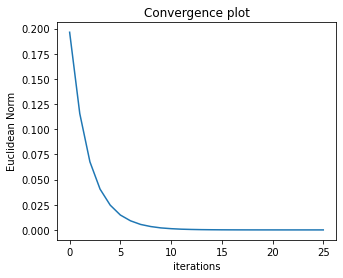


Pagerank importances..
[0.096998   0.05287709 0.05707847 0.03586003 0.02197827 0.02911164
 0.02911164 0.02449063 0.029766   0.01430936 0.02197827 0.00956481
 0.01464499 0.02953655 0.01453592 0.01453592 0.01678428 0.01455878
 0.01453592 0.0196047  0.01453592 0.01455878 0.01453592 0.03152225
 0.02107587 0.02100602 0.01504393 0.0256396  0.01957337 0.02628831
 0.02459009 0.03715792 0.07169251 0.10091826]


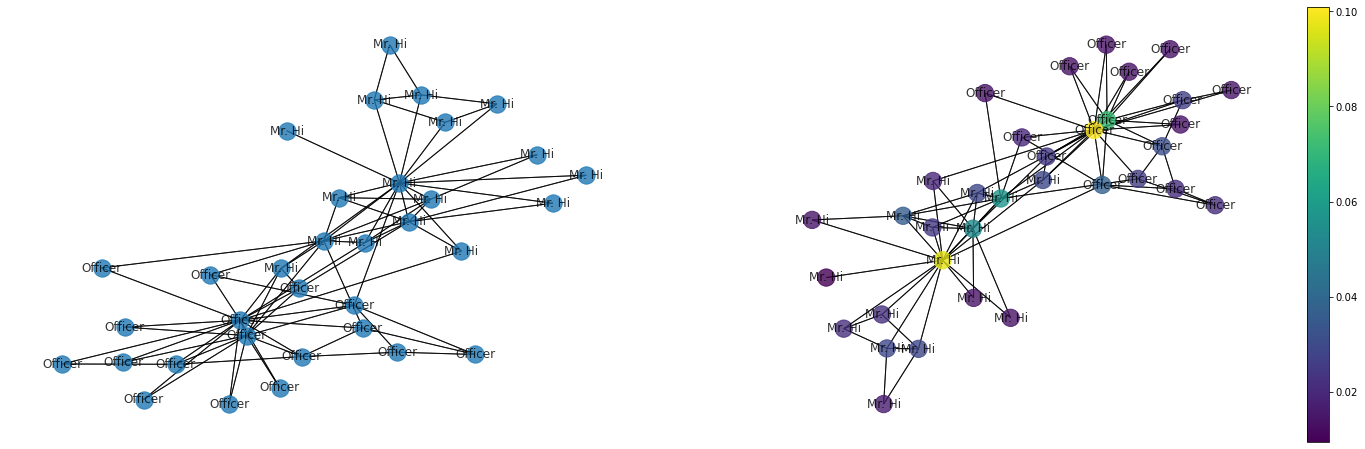

In [7]:
alpha = 0.85
n_iter = 1000

G = nx.karate_club_graph()
final_probs = run(G, alpha, n_iter)

## Davis Southern Woman Graph

Directed: False
Weighted: False

Graph converted to directed..
Directed: True

Relabelling nodes to integers..
Removing isolated nodes..

Number of nodes:  32
Number of edges:  178

Running random walk..
Converged at 63 iterations..


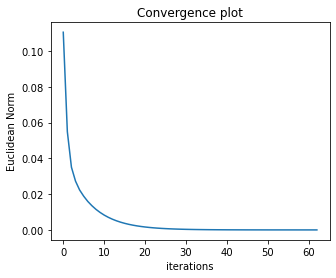


Pagerank importances..
[0.04198744 0.07249745 0.03377786 0.02304914 0.03866227 0.01519948
 0.01896657 0.02300344 0.0182887  0.01896657 0.02262199 0.03239867
 0.02244381 0.02350304 0.01818794 0.03425068 0.03710404 0.03735808
 0.04180355 0.02888959 0.02267941 0.05190154 0.04256327 0.0182518
 0.02305508 0.06660214 0.0138067  0.01519948 0.02726783 0.04453706
 0.04218399 0.02899139]


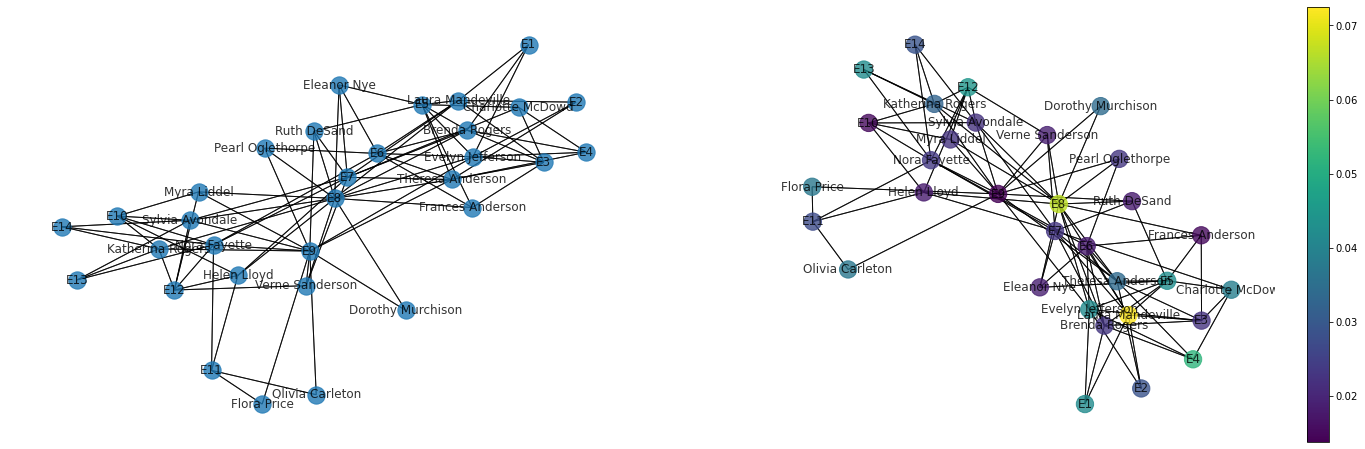

In [8]:
G = nx.davis_southern_women_graph()
final_probs = run(G, alpha, n_iter)

## Florentine Families Graph

Directed: False
Weighted: False

Graph converted to directed..
Directed: True

Relabelling nodes to integers..
Removing isolated nodes..

Number of nodes:  15
Number of edges:  40

Running random walk..
Converged at 38 iterations..


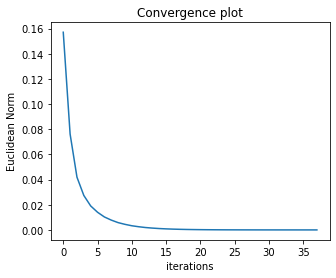


Pagerank importances..
[0.0880984  0.03065754 0.07127986 0.0983975  0.03090963 0.06933012
 0.14581668 0.07912259 0.06787529 0.0613035  0.03241785 0.06957431
 0.03605373 0.0688619  0.05030111]


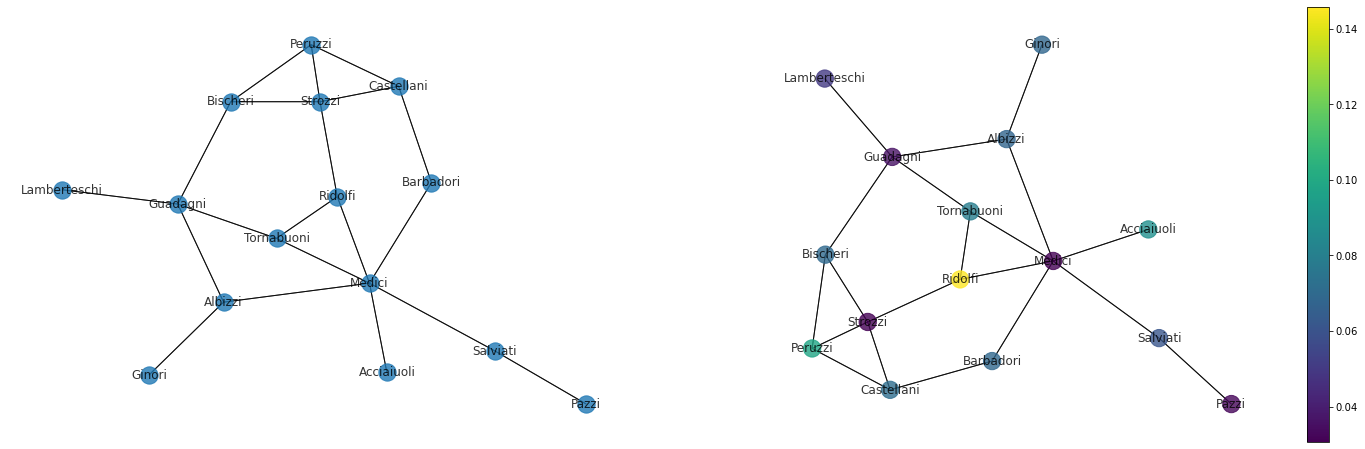

In [9]:
G = nx.florentine_families_graph()
final_probs = run(G, alpha, n_iter)